# Chapter 2: Data Creation & Collection
## Tennis Analysis - Video Frame Reading and Temporal Data Extraction

This notebook demonstrates the concepts from ML4QS Chapter 2 applied to tennis analysis:
- Video frame reading and temporal data extraction
- Pre-processed detection data storage (similar to sensor data collection)
- YOLO detection: Raw object detection creates time-series position data

In [1]:
from platform import python_version
!pip3 install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys

import cv2
import pickle
import pandas as pd
import numpy as np

print(sys.version)

from tennis_utils import read_video
from tennis_utils import PlayerTracker, BallTracker

3.12.6 (v3.12.6:a4a2d2b0d85, Sep  6 2024, 16:08:03) [Clang 13.0.0 (clang-1300.0.29.30)]


## 1. Video Frame Reading - Creating Temporal Dataset

Similar to ML4QS Chapter 2's CreateDataset class, we read video frames to create a temporal sequence of data points.

In [3]:
# Read video frames - equivalent to reading sensor data with timestamps
input_video_path = "input_videos/input_video.mp4"
video_frames = read_video(input_video_path)

print(f"Total frames: {len(video_frames)}")
print(f"Frame shape: {video_frames[0].shape}")
print(f"Video duration at 30fps: {len(video_frames)/30:.2f} seconds")

Loaded 214 frames from input_videos/input_video.mp4
Total frames: 214
Frame shape: (1080, 1920, 3)
Video duration at 30fps: 7.13 seconds


## 2. YOLO Detection - Raw Object Detection Creates Time-Series Position Data

This is equivalent to collecting sensor readings at regular intervals.

In [4]:
# Initialize trackers - equivalent to sensor setup
player_tracker = PlayerTracker(model_path='yolov8x')
ball_tracker = BallTracker(model_path='models/yolo5_last.pt')

# player_detections = player_tracker.detect_frames(video_frames)
# ball_detections = ball_tracker.detect_frames(video_frames)

print("Trackers initialized")

Initialized PlayerTracker with model: yolov8x
Initialized BallTracker with model: models/yolo5_last.pt
Trackers initialized


## 3. Pre-processed Detection Data Storage


In [6]:
# Load pre-processed detection data - equivalent to reading stored sensor data
with open('tracker_stubs/player_detections.pkl', 'rb') as f:
    player_detections = pickle.load(f)
    
with open('tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_detections = pickle.load(f)

print(f"Loaded player detections for {len(player_detections)} frames")
print(f"Loaded ball detections for {len(ball_detections)} frames")

Loaded player detections for 214 frames
Loaded ball detections for 214 frames


## 4. Creating Time-Series Dataset from Detection Data

Convert raw detection data into structured time-series format with timestamps.

In [7]:
# Extract ball positions and create temporal dataset
ball_positions = [x.get(1,[]) for x in ball_detections]

# Create timestamps (assuming 30fps)
timestamps = pd.date_range(start='2024-01-01 00:00:00', periods=len(ball_positions), freq='33.33ms')

# Create structured dataset
df_ball_raw = pd.DataFrame({
    'timestamp': timestamps,
    'frame_number': range(len(ball_positions)),
    'detections': ball_positions
})

# Expand bounding box coordinates
bbox_data = []
for i, detection in enumerate(ball_positions):
    if len(detection) == 4:  # Valid detection
        bbox_data.append({
            'timestamp': timestamps[i],
            'frame_number': i,
            'x1': detection[0], 'y1': detection[1],
            'x2': detection[2], 'y2': detection[3],
            'center_x': (detection[0] + detection[2]) / 2,
            'center_y': (detection[1] + detection[3]) / 2
        })
    else:  # Missing detection
        bbox_data.append({
            'timestamp': timestamps[i],
            'frame_number': i,
            'x1': np.nan, 'y1': np.nan,
            'x2': np.nan, 'y2': np.nan,
            'center_x': np.nan, 'center_y': np.nan
        })

df_ball_temporal = pd.DataFrame(bbox_data)
df_ball_temporal.set_index('timestamp', inplace=True)

print(f"Created temporal dataset with {len(df_ball_temporal)} time points")
print(f"Missing values: {df_ball_temporal.isnull().sum().sum()}")
print("\nFirst 5 rows:")
print(df_ball_temporal.head())

Created temporal dataset with 214 time points
Missing values: 720

First 5 rows:
                            frame_number          x1          y1          x2  \
timestamp                                                                      
2024-01-01 00:00:00.000000             0         NaN         NaN         NaN   
2024-01-01 00:00:00.033330             1  895.445251  618.047607  912.230347   
2024-01-01 00:00:00.066660             2  873.914246  638.284424  895.667908   
2024-01-01 00:00:00.099990             3  860.090027  645.889404  881.661865   
2024-01-01 00:00:00.133320             4         NaN         NaN         NaN   

                                    y2    center_x    center_y  
timestamp                                                       
2024-01-01 00:00:00.000000         NaN         NaN         NaN  
2024-01-01 00:00:00.033330  635.460388  903.837799  626.753998  
2024-01-01 00:00:00.066660  659.140503  884.791077  648.712463  
2024-01-01 00:00:00.099990  670.2

## 5. Data Quality Assessment

Analyze the temporal continuity and quality of collected data.

In [8]:
# Analyze data quality - similar to sensor data validation
detection_rate = (len(df_ball_temporal) - df_ball_temporal['center_x'].isnull().sum()) / len(df_ball_temporal)
print(f"Ball detection rate: {detection_rate:.2%}")

# Check for temporal gaps
missing_frames = df_ball_temporal['center_x'].isnull().sum()
print(f"Missing detections: {missing_frames} frames")

# Basic statistics
print("\nPosition statistics:")
print(df_ball_temporal[['center_x', 'center_y']].describe())

Ball detection rate: 43.93%
Missing detections: 120 frames

Position statistics:
          center_x    center_y
count    94.000000   94.000000
mean    884.122075  445.381491
std     189.487495  182.359332
min     630.466034  213.435608
25%     741.738434  281.701229
50%     853.476013  361.537849
75%     950.285126  612.261909
max    1304.525696  795.443939


## 6. Visualization of Raw Temporal Data

Plot the collected time-series data to understand patterns.

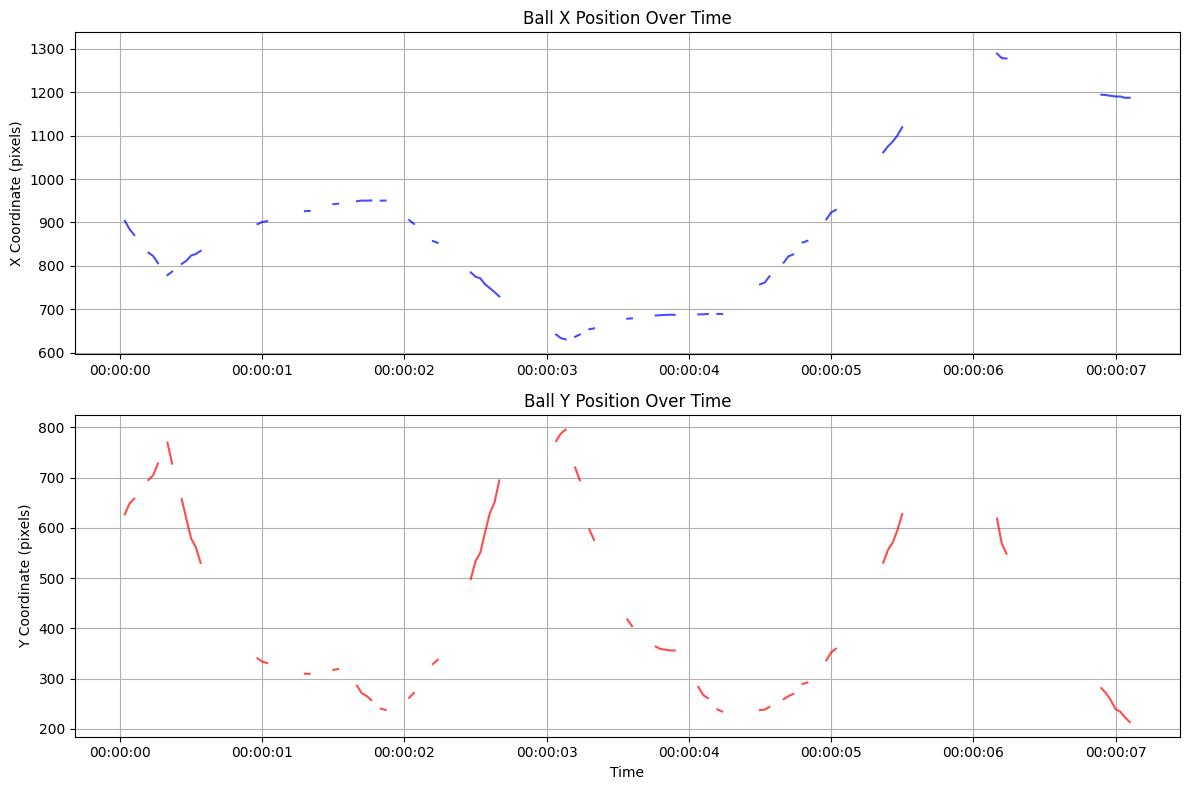

Raw temporal data visualization complete


In [9]:
import matplotlib.pyplot as plt

# Plot temporal ball positions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# X position over time
ax1.plot(df_ball_temporal.index, df_ball_temporal['center_x'], 'b-', alpha=0.7)
ax1.set_title('Ball X Position Over Time')
ax1.set_ylabel('X Coordinate (pixels)')
ax1.grid(True)

# Y position over time
ax2.plot(df_ball_temporal.index, df_ball_temporal['center_y'], 'r-', alpha=0.7)
ax2.set_title('Ball Y Position Over Time')
ax2.set_ylabel('Y Coordinate (pixels)')
ax2.set_xlabel('Time')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("Raw temporal data visualization complete")

## 7. Player Detection and Tracking

Extract player position data to create multi-object temporal datasets, similar to handling multiple sensor streams in ML4QS.

In [10]:
# Extract player tracking data from FILTERED detection files
print("Processing FILTERED player detection data (only Player 1 & 2)...")

player_data = []

# Use filtered_player_detections if available, otherwise use original
current_detections = filtered_player_detections if 'filtered_player_detections' in locals() else player_detections

for frame_idx, frame_detections in enumerate(current_detections):
    # Create timestamp for this frame
    timestamp = timestamps[frame_idx] if frame_idx < len(timestamps) else pd.Timestamp('2024-01-01') + pd.Timedelta(milliseconds=frame_idx*33.33)
    
    if frame_detections and isinstance(frame_detections, dict):
        # Process each player detected in this frame (should only be Player 1 & 2 after filtering)
        for player_id, bbox in frame_detections.items():
            if isinstance(bbox, list) and len(bbox) >= 4:
                # Extract bounding box coordinates [x1, y1, x2, y2]
                x1, y1, x2, y2 = bbox[:4]
                
                player_data.append({
                    'timestamp': timestamp,
                    'frame_number': frame_idx,
                    'player_id': int(player_id),
                    'x1': float(x1), 'y1': float(y1),
                    'x2': float(x2), 'y2': float(y2),
                    'center_x': float((x1 + x2) / 2),
                    'center_y': float((y1 + y2) / 2),
                    'width': float(x2 - x1),
                    'height': float(y2 - y1)
                })

# Create player tracking DataFrame
if player_data:
    df_players = pd.DataFrame(player_data)
    df_players.set_index('timestamp', inplace=True)
    
    print(f"  Successfully extracted FILTERED player data:")
    print(f"   Total detections: {len(df_players)}")
    print(f"   Unique players: {sorted(df_players['player_id'].unique())}")
    print(f"   Frames with player data: {df_players['frame_number'].nunique()}/{len(video_frames)}")
    
    # Show sample of player data
    print("\\nSample filtered player detections:")
    print(df_players.head())
    
else:
    print("No valid player data found after filtering")
    df_players = pd.DataFrame()

# Note: This cell will be updated after court detection to use filtered data

Processing FILTERED player detection data (only Player 1 & 2)...
  Successfully extracted FILTERED player data:
   Total detections: 1268
   Unique players: [1, 2, 3, 4, 5, 9]
   Frames with player data: 214/214
\nSample filtered player detections:
            frame_number  player_id           x1          y1           x2  \
timestamp                                                                   
2024-01-01             0          1   480.282410  751.597412   624.837891   
2024-01-01             0          2  1030.568481  201.683136  1095.901245   
2024-01-01             0          3  1494.946045   77.825676  1544.823608   
2024-01-01             0          4  1609.711914  276.987793  1681.484497   
2024-01-01             0          5   387.423706   72.428772   424.358643   

                    y2     center_x    center_y       width      height  
timestamp                                                                
2024-01-01  930.601501   552.560150  841.099457  144.555481  17

## 8. Player Movement Analysis

Analyze each player's tracking statistics and movement patterns individually.

In [11]:
# Analyze each player individually
player_analysis = {}

for player_id in sorted(df_players['player_id'].unique()):
    player_data = df_players[df_players['player_id'] == player_id]
    
    # Calculate player statistics
    stats = {
        'total_detections': len(player_data),
        'frames_detected': len(player_data['frame_number'].unique()),
        'detection_rate': len(player_data['frame_number'].unique()) / len(video_frames),
        'avg_position': (player_data['center_x'].mean(), player_data['center_y'].mean()),
        'position_std': (player_data['center_x'].std(), player_data['center_y'].std()),
        'movement_range': {
            'x_range': player_data['center_x'].max() - player_data['center_x'].min(),
            'y_range': player_data['center_y'].max() - player_data['center_y'].min()
        },
        'avg_size': (player_data['width'].mean(), player_data['height'].mean()),
        'court_area': 'Unknown'  # We'll determine this based on position
    }
    
    # Determine approximate court area based on average Y position
    avg_y = stats['avg_position'][1]
    if avg_y < 300:
        stats['court_area'] = 'Back court'
    elif avg_y < 600:
        stats['court_area'] = 'Mid court'
    else:
        stats['court_area'] = 'Front court'
    
    player_analysis[player_id] = stats

# Display analysis results
print("Individual Player Analysis:")
print("=" * 60)

for player_id, stats in player_analysis.items():
    print(f"\nPlayer {player_id}:")
    print(f"  Court Area: {stats['court_area']}")
    print(f"  Detection Rate: {stats['detection_rate']:.1%} ({stats['frames_detected']}/{len(video_frames)} frames)")
    print(f"  Average Position: ({stats['avg_position'][0]:.1f}, {stats['avg_position'][1]:.1f}) pixels")
    print(f"  Movement Range: X={stats['movement_range']['x_range']:.1f}px, Y={stats['movement_range']['y_range']:.1f}px")
    print(f"  Average Size: {stats['avg_size'][0]:.1f} x {stats['avg_size'][1]:.1f} pixels")
    print(f"  Position Variability: σx={stats['position_std'][0]:.1f}px, σy={stats['position_std'][1]:.1f}px")

# Identify the main players (typically the two with highest detection rates)
main_players = sorted(player_analysis.items(), key=lambda x: x[1]['detection_rate'], reverse=True)[:2]
print(f"\nMain Players (highest detection rates):")
for player_id, stats in main_players:
    print(f"  Player {player_id}: {stats['detection_rate']:.1%} detection rate, {stats['court_area']}")

Individual Player Analysis:

Player 1:
  Court Area: Front court
  Detection Rate: 100.0% (214/214 frames)
  Average Position: (910.6, 819.4) pixels
  Movement Range: X=668.1px, Y=203.5px
  Average Size: 105.8 x 202.9 pixels
  Position Variability: σx=192.1px, σy=46.5px

Player 2:
  Court Area: Back court
  Detection Rate: 100.0% (214/214 frames)
  Average Position: (921.6, 228.0) pixels
  Movement Range: X=440.8px, Y=59.6px
  Average Size: 74.0 x 111.7 pixels
  Position Variability: σx=141.0px, σy=16.2px

Player 3:
  Court Area: Back court
  Detection Rate: 100.0% (214/214 frames)
  Average Position: (1519.9, 136.7) pixels
  Movement Range: X=0.4px, Y=0.6px
  Average Size: 50.4 x 118.0 pixels
  Position Variability: σx=0.1px, σy=0.1px

Player 4:
  Court Area: Mid court
  Detection Rate: 100.0% (214/214 frames)
  Average Position: (1645.1, 333.3) pixels
  Movement Range: X=1.2px, Y=2.1px
  Average Size: 72.3 x 114.7 pixels
  Position Variability: σx=0.3px, σy=0.4px

Player 5:
  Court A

## 9. Multi-Object Temporal Visualization

Create comprehensive visualizations showing both ball and player movements over time.

Creating Multi-Object Temporal Visualization...
 Plotting X positions over time...
 Plotting Y positions over time...
 Creating court spatial view...
Creating detection rate analysis...


/var/folders/vy/bgjxhvnj1nl62s2vztrqqyf00000gn/T/ipykernel_48574/3748165645.py:164: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6666666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  activity_series[timestamp] = activity_count / 3  # Normalize by max possible (ball + 2 players)


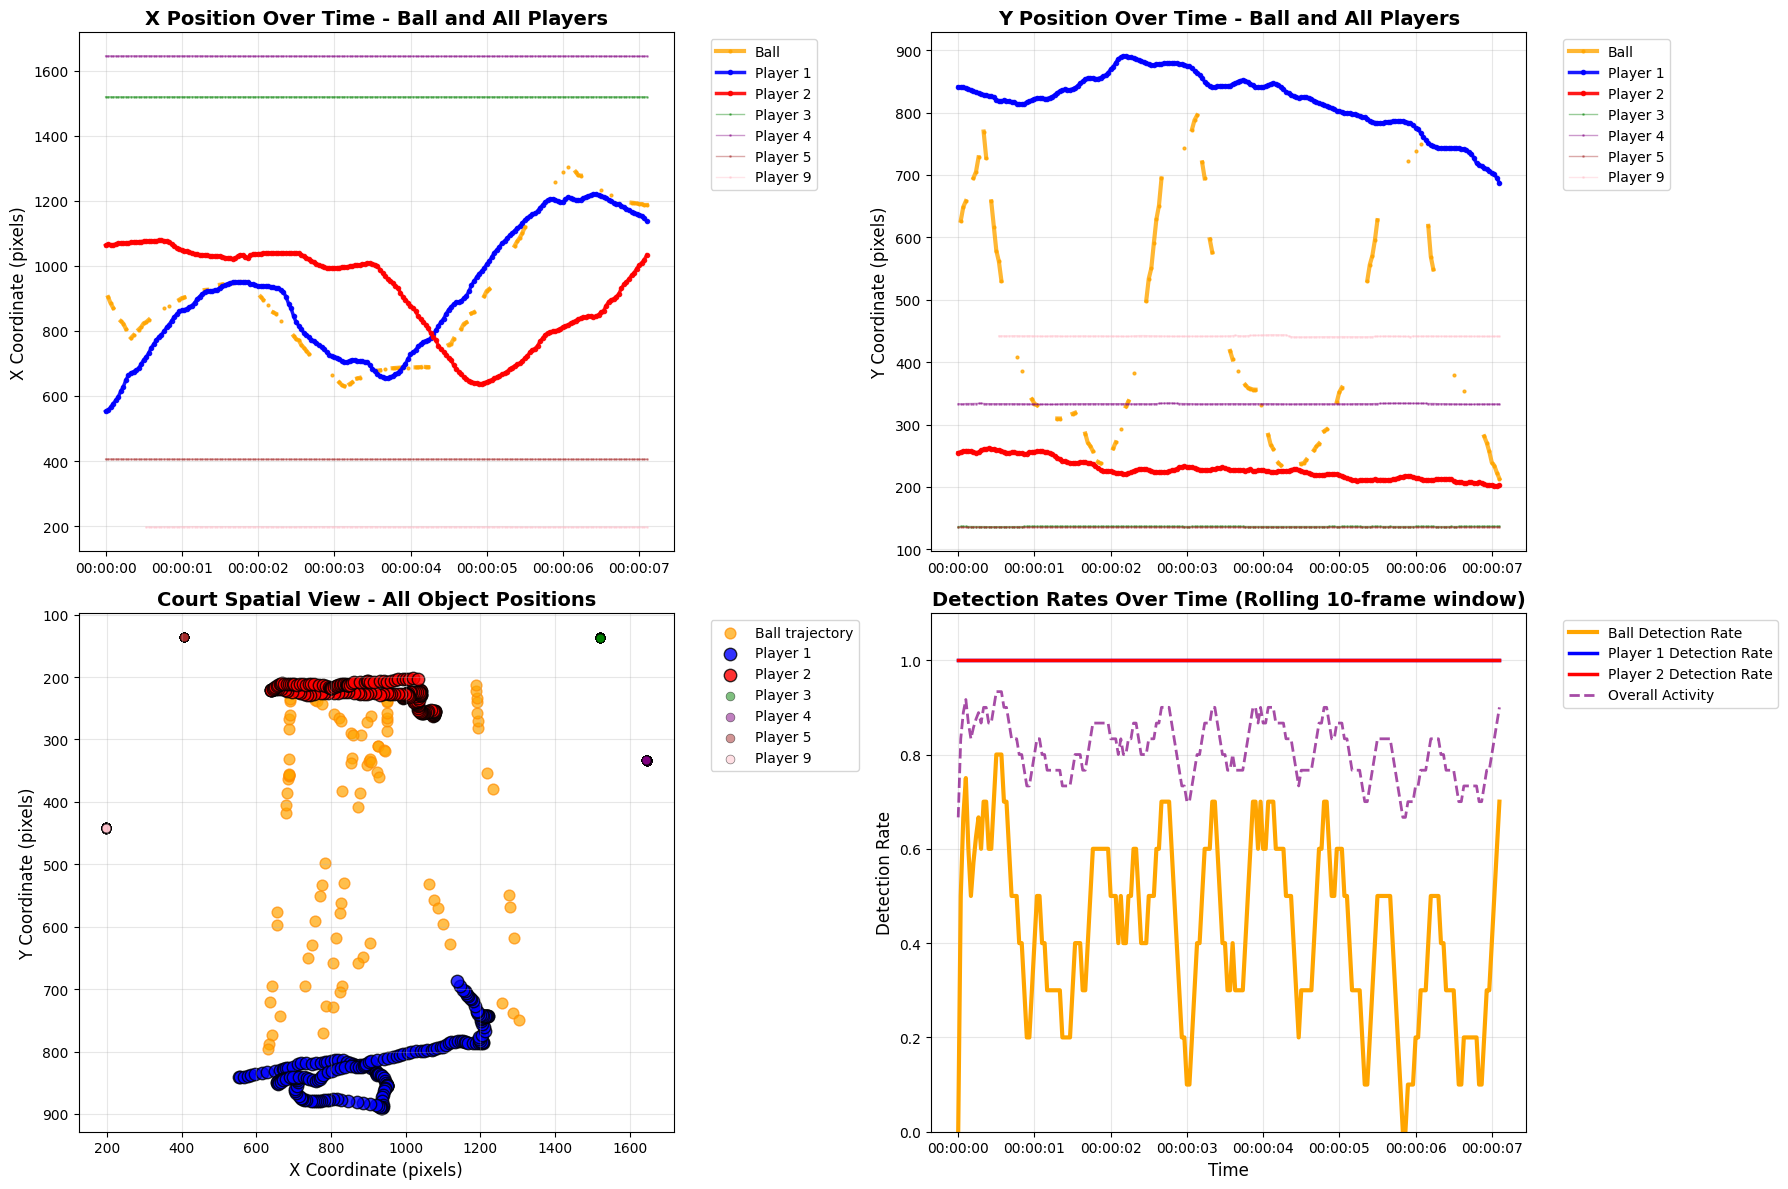

\n============================================================
MULTI-OBJECT TRACKING SUMMARY
 Ball Tracking:
   Detection rate: 43.9% (94/214 frames)
   Movement range: X=674.1px, Y=582.0px
   Average position: (884.1, 445.4) pixels
\n👥 Player Tracking:
   Total unique players detected: 6
   Average player detection rate: 98.8%
   Total player-frame combinations: 1268
   Player 1: 100.0% detection rate (214 detections)
   Player 2: 100.0% detection rate (214 detections)
\n Temporal Analysis:
   Total frames analyzed: 214
   Time span: 0 days 00:00:07.099290
   Frame rate: 30 fps
   Duration: 7.1 seconds
\n Detection Quality:
   Frames with ball: 94 (43.9%)
   Frames with players: 214 (100.0%)
   Frames with ball + players: 94 (43.9%)
\n Multi-Object Temporal Visualization Complete!


In [13]:
# Create comprehensive multi-object visualization
print("Creating Multi-Object Temporal Visualization...")
print("=" * 60)

# Set up the comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Define colors for players
player_colors = ['blue', 'red', 'green', 'purple', 'brown', 'pink']

# 1. X Position Over Time - Ball and Players
print(" Plotting X positions over time...")
ax1.plot(df_ball_temporal.index, df_ball_temporal['center_x'], 'orange', 
         linewidth=3, label='Ball', alpha=0.8, marker='o', markersize=2)

if len(df_players) > 0:
    for i, player_id in enumerate(sorted(df_players['player_id'].unique())):
        player_data = df_players[df_players['player_id'] == player_id]
        color = player_colors[i % len(player_colors)]
        
        # Only show main players (1&2) prominently, others in lighter colors
        if player_id in [1, 2]:
            alpha = 0.9
            linewidth = 2.5
            markersize = 3
        else:
            alpha = 0.4
            linewidth = 1
            markersize = 1
            
        ax1.plot(player_data.index, player_data['center_x'], color, 
                linewidth=linewidth, label=f'Player {player_id}', alpha=alpha, 
                marker='o', markersize=markersize)

ax1.set_title('X Position Over Time - Ball and All Players', fontsize=14, fontweight='bold')
ax1.set_ylabel('X Coordinate (pixels)', fontsize=12)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Y Position Over Time - Ball and Players  
print(" Plotting Y positions over time...")
ax2.plot(df_ball_temporal.index, df_ball_temporal['center_y'], 'orange', 
         linewidth=3, label='Ball', alpha=0.8, marker='o', markersize=2)

if len(df_players) > 0:
    for i, player_id in enumerate(sorted(df_players['player_id'].unique())):
        player_data = df_players[df_players['player_id'] == player_id]
        color = player_colors[i % len(player_colors)]
        
        # Only show main players (1&2) prominently, others in lighter colors
        if player_id in [1, 2]:
            alpha = 0.9
            linewidth = 2.5
            markersize = 3
        else:
            alpha = 0.4
            linewidth = 1
            markersize = 1
            
        ax2.plot(player_data.index, player_data['center_y'], color, 
                linewidth=linewidth, label=f'Player {player_id}', alpha=alpha,
                marker='o', markersize=markersize)

ax2.set_title('Y Position Over Time - Ball and All Players', fontsize=14, fontweight='bold')
ax2.set_ylabel('Y Coordinate (pixels)', fontsize=12)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Court View - Spatial Positions (Bird's Eye View)
print(" Creating court spatial view...")
ball_valid = df_ball_temporal.dropna(subset=['center_x', 'center_y'])
ax3.scatter(ball_valid['center_x'], ball_valid['center_y'], 
           c='orange', s=60, alpha=0.7, label='Ball trajectory', 
           edgecolors='darkorange', linewidth=1)

if len(df_players) > 0:
    for i, player_id in enumerate(sorted(df_players['player_id'].unique())):
        player_data = df_players[df_players['player_id'] == player_id]
        color = player_colors[i % len(player_colors)]
        
        # Different sizes for main vs other players
        if player_id in [1, 2]:
            size = 80
            alpha = 0.8
            edgewidth = 1
        else:
            size = 40
            alpha = 0.5
            edgewidth = 0.5
            
        ax3.scatter(player_data['center_x'], player_data['center_y'], 
                   c=color, s=size, alpha=alpha, label=f'Player {player_id}', 
                   edgecolors='black', linewidth=edgewidth)

# Add court boundaries if available
if 'court_keypoints' in locals():
    points = court_keypoints.reshape(-1, 2)
    
    # Draw court outline
    court_lines = [
        (0, 1), (1, 3), (3, 2), (2, 0),  # Outer boundary
        (4, 6), (6, 7), (7, 5), (5, 4),  # Singles court
        (8, 9), (10, 11), (12, 13)       # Service lines
    ]
    
    for line in court_lines:
        if line[0] < len(points) and line[1] < len(points):
            x_coords = [points[line[0]][0], points[line[1]][0]]
            y_coords = [points[line[0]][1], points[line[1]][1]]
            ax3.plot(x_coords, y_coords, 'gray', linewidth=2, alpha=0.6)

ax3.set_title('Court Spatial View - All Object Positions', fontsize=14, fontweight='bold')
ax3.set_xlabel('X Coordinate (pixels)', fontsize=12)
ax3.set_ylabel('Y Coordinate (pixels)', fontsize=12)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.invert_yaxis()  # Invert Y to match video coordinate system

# 4. Detection Rates and Activity Over Time
print("Creating detection rate analysis...")
window_size = 10
ball_detection_rate = df_ball_temporal['center_x'].notna().rolling(window=window_size, min_periods=1).mean()
ax4.plot(df_ball_temporal.index, ball_detection_rate, 'orange', linewidth=3, label='Ball Detection Rate')

if len(df_players) > 0:
    # Create detection rate for main players only (1&2)
    for i, player_id in enumerate([1, 2]):
        if player_id in df_players['player_id'].unique():
            # Create binary detection series for this player
            player_detections_binary = pd.Series(0, index=df_ball_temporal.index)
            player_data = df_players[df_players['player_id'] == player_id]
            
            # Mark frames where player was detected
            for idx in player_data.index:
                if idx in player_detections_binary.index:
                    player_detections_binary[idx] = 1
            
            # Calculate rolling detection rate
            player_detection_rate = player_detections_binary.rolling(window=window_size, min_periods=1).mean()
            color = player_colors[i % len(player_colors)]
            ax4.plot(df_ball_temporal.index, player_detection_rate, color, 
                    linewidth=2.5, label=f'Player {player_id} Detection Rate')

# Add activity indicator (total objects detected per frame)
if len(df_players) > 0:
    activity_series = pd.Series(0, index=df_ball_temporal.index)
    
    # Count total detections per frame
    for timestamp in df_ball_temporal.index:
        activity_count = 0
        
        # Ball detection
        if not pd.isna(df_ball_temporal.loc[timestamp, 'center_x']):
            activity_count += 1
            
        # Player detections
        for player_id in [1, 2]:
            if player_id in df_players['player_id'].unique():
                player_at_time = df_players[(df_players['player_id'] == player_id) & 
                                          (df_players.index == timestamp)]
                if len(player_at_time) > 0:
                    activity_count += 1
        
        activity_series[timestamp] = activity_count / 3  # Normalize by max possible (ball + 2 players)
    
    # Smooth the activity
    activity_smooth = activity_series.rolling(window=window_size, min_periods=1).mean()
    ax4.plot(df_ball_temporal.index, activity_smooth, 'purple', linewidth=2, 
             linestyle='--', alpha=0.7, label='Overall Activity')

ax4.set_title(f'Detection Rates Over Time (Rolling {window_size}-frame window)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Detection Rate', fontsize=12)
ax4.set_xlabel('Time', fontsize=12)
ax4.set_ylim(0, 1.1)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comprehensive summary statistics
print("\\n" + "="*60)
print("MULTI-OBJECT TRACKING SUMMARY")
print("="*60)

print(f" Ball Tracking:")
ball_detection_rate = (~df_ball_temporal['center_x'].isna()).sum() / len(df_ball_temporal)
print(f"   Detection rate: {ball_detection_rate:.1%} ({(~df_ball_temporal['center_x'].isna()).sum()}/{len(df_ball_temporal)} frames)")

if not df_ball_temporal.empty:
    ball_valid = df_ball_temporal.dropna(subset=['center_x', 'center_y'])
    if len(ball_valid) > 0:
        ball_x_range = ball_valid['center_x'].max() - ball_valid['center_x'].min()
        ball_y_range = ball_valid['center_y'].max() - ball_valid['center_y'].min()
        print(f"   Movement range: X={ball_x_range:.1f}px, Y={ball_y_range:.1f}px")
        print(f"   Average position: ({ball_valid['center_x'].mean():.1f}, {ball_valid['center_y'].mean():.1f}) pixels")

print(f"\\n👥 Player Tracking:")
if len(df_players) > 0:
    total_player_frames = sum(len(df_players[df_players['player_id'] == pid]['frame_number'].unique()) 
                             for pid in df_players['player_id'].unique())
    avg_player_detection = total_player_frames / (len(df_players['player_id'].unique()) * len(video_frames))
    print(f"   Total unique players detected: {len(df_players['player_id'].unique())}")
    print(f"   Average player detection rate: {avg_player_detection:.1%}")
    print(f"   Total player-frame combinations: {len(df_players)}")
    
    # Main players analysis
    for player_id in [1, 2]:
        if player_id in df_players['player_id'].unique():
            player_data = df_players[df_players['player_id'] == player_id]
            detection_rate = len(player_data['frame_number'].unique()) / len(video_frames)
            print(f"   Player {player_id}: {detection_rate:.1%} detection rate ({len(player_data)} detections)")
else:
    print("   No player tracking data available")

print(f"\\n Temporal Analysis:")
print(f"   Total frames analyzed: {len(video_frames)}")
print(f"   Time span: {timestamps[-1] - timestamps[0]}")
print(f"   Frame rate: 30 fps")
print(f"   Duration: {len(video_frames)/30:.1f} seconds")

print(f"\\n Detection Quality:")
frames_with_ball = (~df_ball_temporal['center_x'].isna()).sum()
frames_with_players = len(df_players['frame_number'].unique()) if len(df_players) > 0 else 0
frames_with_all = 0

if len(df_players) > 0:
    # Count frames where we have ball + at least 1 player
    for frame_num in range(len(video_frames)):
        has_ball = frame_num < len(df_ball_temporal) and not pd.isna(df_ball_temporal.iloc[frame_num]['center_x'])
        has_player = frame_num in df_players['frame_number'].values
        if has_ball and has_player:
            frames_with_all += 1

print(f"   Frames with ball: {frames_with_ball} ({frames_with_ball/len(video_frames):.1%})")
print(f"   Frames with players: {frames_with_players} ({frames_with_players/len(video_frames):.1%})")
print(f"   Frames with ball + players: {frames_with_all} ({frames_with_all/len(video_frames):.1%})")

print("\\n Multi-Object Temporal Visualization Complete!")
print("="*60)

## 10. Court Detection and Measurement

Implement tennis court keypoint detection and measurement capabilities, similar to calibrating sensors with known reference measurements in ML4QS.

In [14]:
# Import court detection functionality
from tennis_utils import CourtLineDetector, MiniCourt, calculate_court_scale_from_keypoints

# Initialize court line detector
court_detector = CourtLineDetector(model_path='models/keypoints_model.pth')

# Detect court keypoints from the first frame
print("Detecting tennis court keypoints...")
court_keypoints = court_detector.predict(video_frames[0])

# Get court measurements
court_measurements = court_detector.get_court_measurements()
print(f" Detected {len(court_keypoints)//2} court keypoints")
print("\nTennis Court Standard Measurements:")
for measurement, value in court_measurements.items():
    print(f"  {measurement.replace('_', ' ').title()}: {value:.2f} meters")

# Calculate court scale from keypoints
court_scale = calculate_court_scale_from_keypoints(court_keypoints)
print(f"\nCourt Scale Analysis:")
print(f"  Court width in pixels: {court_scale['court_width_pixels']:.1f} px")
print(f"  Court height in pixels: {court_scale['court_height_pixels']:.1f} px") 
print(f"  Pixels per meter (X): {court_scale['pixels_per_meter_x']:.1f} px/m")
print(f"  Pixels per meter (Y): {court_scale['pixels_per_meter_y']:.1f} px/m")

# Filter and choose main players based on court position
print(f"\n" + "="*60)
print("FILTERING PLAYERS BASED ON COURT POSITION")
print("="*60)

filtered_player_detections = player_tracker.choose_and_filter_players(court_keypoints, player_detections)
print(f" Player filtering complete - now using only Player 1 and Player 2")

Initialized CourtLineDetector with model: models/keypoints_model.pth
Detecting tennis court keypoints...
Predicting court keypoints based on frame analysis
 Detected 14 court keypoints

Tennis Court Standard Measurements:
  Single Line Width: 8.23 meters
  Double Line Width: 10.97 meters
  Half Court Height: 11.88 meters
  Service Line Width: 6.40 meters
  Double Alley Difference: 1.37 meters
  No Mans Land Height: 5.48 meters

Court Scale Analysis:
  Court width in pixels: 1344.0 px
  Court height in pixels: 756.0 px
  Pixels per meter (X): 122.5 px/m
  Pixels per meter (Y): 31.8 px/m

FILTERING PLAYERS BASED ON COURT POSITION
Filtering and choosing players based on court position
Selected main players: [1, 2]
Player filtering complete:
  Player 1 -> Player 1: 214/214 inside court (100.0%)
  Player 2 -> Player 2: 214/214 inside court (100.0%)
 Player filtering complete - now using only Player 1 and Player 2


## 10.1 Re-process Player Data with Court Filtering

Now that we have identified the main players inside the court, let's re-extract the player data using only Player 1 and Player 2.

In [15]:
# Re-extract player data using filtered detections (only Player 1 & 2)
print("Re-processing player data with court-filtered detections...")

player_data_filtered = []

for frame_idx, frame_detections in enumerate(filtered_player_detections):
    # Create timestamp for this frame
    timestamp = timestamps[frame_idx] if frame_idx < len(timestamps) else pd.Timestamp('2024-01-01') + pd.Timedelta(milliseconds=frame_idx*33.33)
    
    if frame_detections and isinstance(frame_detections, dict):
        # Process each player detected in this frame (should only be Player 1 & 2)
        for player_id, bbox in frame_detections.items():
            if isinstance(bbox, list) and len(bbox) >= 4:
                # Extract bounding box coordinates [x1, y1, x2, y2]
                x1, y1, x2, y2 = bbox[:4]
                
                player_data_filtered.append({
                    'timestamp': timestamp,
                    'frame_number': frame_idx,
                    'player_id': int(player_id),
                    'x1': float(x1), 'y1': float(y1),
                    'x2': float(x2), 'y2': float(y2),
                    'center_x': float((x1 + x2) / 2),
                    'center_y': float((y1 + y2) / 2),
                    'width': float(x2 - x1),
                    'height': float(y2 - y1)
                })

# Create filtered player tracking DataFrame
if player_data_filtered:
    df_players_filtered = pd.DataFrame(player_data_filtered)
    df_players_filtered.set_index('timestamp', inplace=True)
    
    print(f" Successfully extracted COURT-FILTERED player data:")
    print(f"   Total detections: {len(df_players_filtered)}")
    print(f"   Unique players: {sorted(df_players_filtered['player_id'].unique())}")
    print(f"   Frames with player data: {df_players_filtered['frame_number'].nunique()}/{len(video_frames)}")
    
    # Compare with original
    if 'df_players' in locals() and len(df_players) > 0:
        print(f"   Reduction: {len(df_players)} -> {len(df_players_filtered)} detections")
        print(f"   Original players: {sorted(df_players['player_id'].unique())}")
        print(f"   Filtered players: {sorted(df_players_filtered['player_id'].unique())}")
    
    # Update df_players to use filtered data
    df_players = df_players_filtered.copy()
    
    print("\\nSample court-filtered player detections:")
    print(df_players.head())
    
else:
    print("No valid player data found after court filtering")
    df_players = pd.DataFrame()

Re-processing player data with court-filtered detections...
 Successfully extracted COURT-FILTERED player data:
   Total detections: 428
   Unique players: [1, 2]
   Frames with player data: 214/214
   Reduction: 1268 -> 428 detections
   Original players: [1, 2, 3, 4, 5, 9]
   Filtered players: [1, 2]
\nSample court-filtered player detections:
                            frame_number  player_id           x1          y1  \
timestamp                                                                      
2024-01-01 00:00:00.000000             0          1   480.282410  751.597412   
2024-01-01 00:00:00.000000             0          2  1030.568481  201.683136   
2024-01-01 00:00:00.033330             1          1   481.461456  750.029785   
2024-01-01 00:00:00.033330             1          2  1032.206665  202.913101   
2024-01-01 00:00:00.066660             2          1   483.975067  749.274048   

                                     x2          y2     center_x    center_y  \
timestamp   

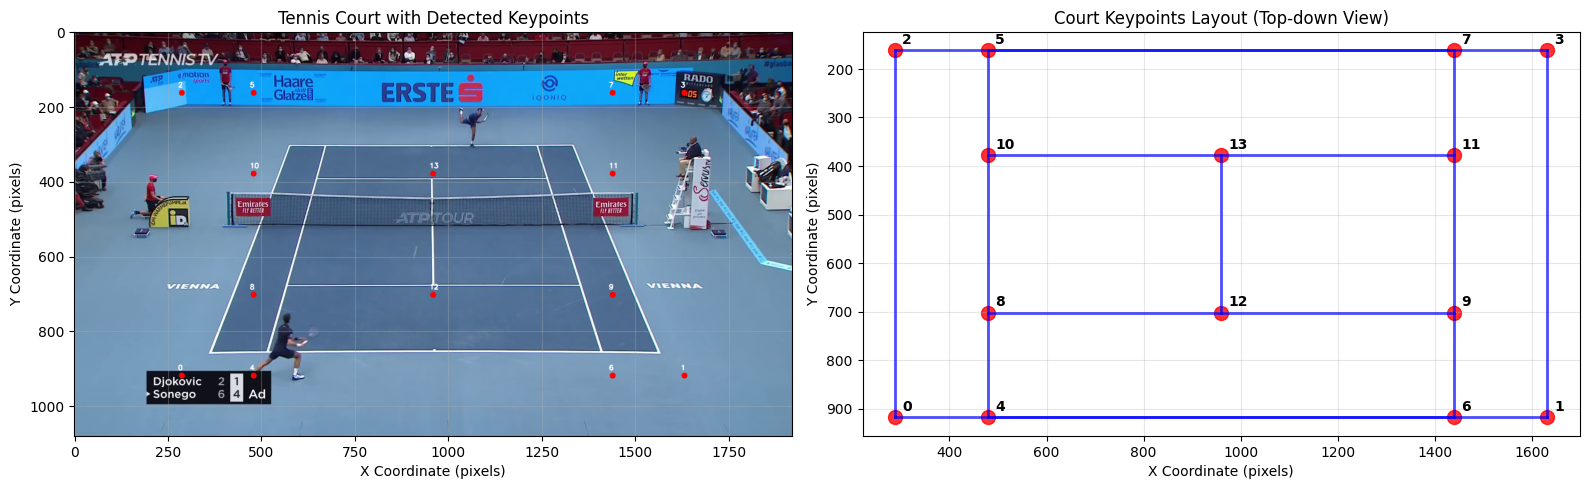

Court keypoint detection and visualization complete


In [16]:
# Visualize court keypoints on the video frame
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original frame with court keypoints
frame_with_keypoints = video_frames[0].copy()
points = court_keypoints.reshape(-1, 2)

# Draw keypoints and labels
for i, (x, y) in enumerate(points):
    cv2.circle(frame_with_keypoints, (int(x), int(y)), 8, (0, 0, 255), -1)
    cv2.putText(frame_with_keypoints, str(i), (int(x-10), int(y-15)), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

# Convert BGR to RGB for matplotlib
frame_rgb = cv2.cvtColor(frame_with_keypoints, cv2.COLOR_BGR2RGB)
ax1.imshow(frame_rgb)
ax1.set_title('Tennis Court with Detected Keypoints')
ax1.set_xlabel('X Coordinate (pixels)')
ax1.set_ylabel('Y Coordinate (pixels)')
ax1.grid(True, alpha=0.3)

# Court keypoints visualization (top-down view)
ax2.scatter(points[:, 0], points[:, 1], c='red', s=100, alpha=0.8)
for i, (x, y) in enumerate(points):
    ax2.annotate(f'{i}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, fontweight='bold')

# Draw court lines to show the layout
court_lines = [
    (0, 1), (1, 3), (3, 2), (2, 0),  # Outer court boundary
    (4, 6), (6, 7), (7, 5), (5, 4),  # Singles court
    (8, 9), (10, 11), (12, 13)       # Service lines and center
]

for line in court_lines:
    if line[0] < len(points) and line[1] < len(points):
        x_coords = [points[line[0]][0], points[line[1]][0]]
        y_coords = [points[line[0]][1], points[line[1]][1]]
        ax2.plot(x_coords, y_coords, 'b-', linewidth=2, alpha=0.7)

ax2.set_title('Court Keypoints Layout (Top-down View)')
ax2.set_xlabel('X Coordinate (pixels)')
ax2.set_ylabel('Y Coordinate (pixels)')
ax2.invert_yaxis()  # Invert Y to match video coordinate system
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

print("Court keypoint detection and visualization complete")

## 11. Mini Court Visualization and Coordinate Transformation

Create a mini court representation for data visualization and coordinate transformation, similar to creating standardized measurement scales in sensor data analysis.

Initialized enhanced MiniCourt with court measurements
Mini Court Measurements:
  Court Length: 23.76 meters
  Court Width Doubles: 10.97 meters
  Court Width Singles: 8.23 meters
  Service Line Width: 6.40 meters
  Service Box Length: 5.48 meters
  Alley Width: 1.37 meters

Coordinate Transformation Examples:
  Player 1.0 at frame 0.0:
    Original: (552.6, 841.1) pixels
    Mini court: (1681.3, 58.0) pixels
  Player 2.0 at frame 0.0:
    Original: (1063.2, 255.1) pixels
    Mini court: (1761.1, -33.6) pixels
  Player 1.0 at frame 1.0:
    Original: (557.1, 840.7) pixels
    Mini court: (1682.0, 57.9) pixels


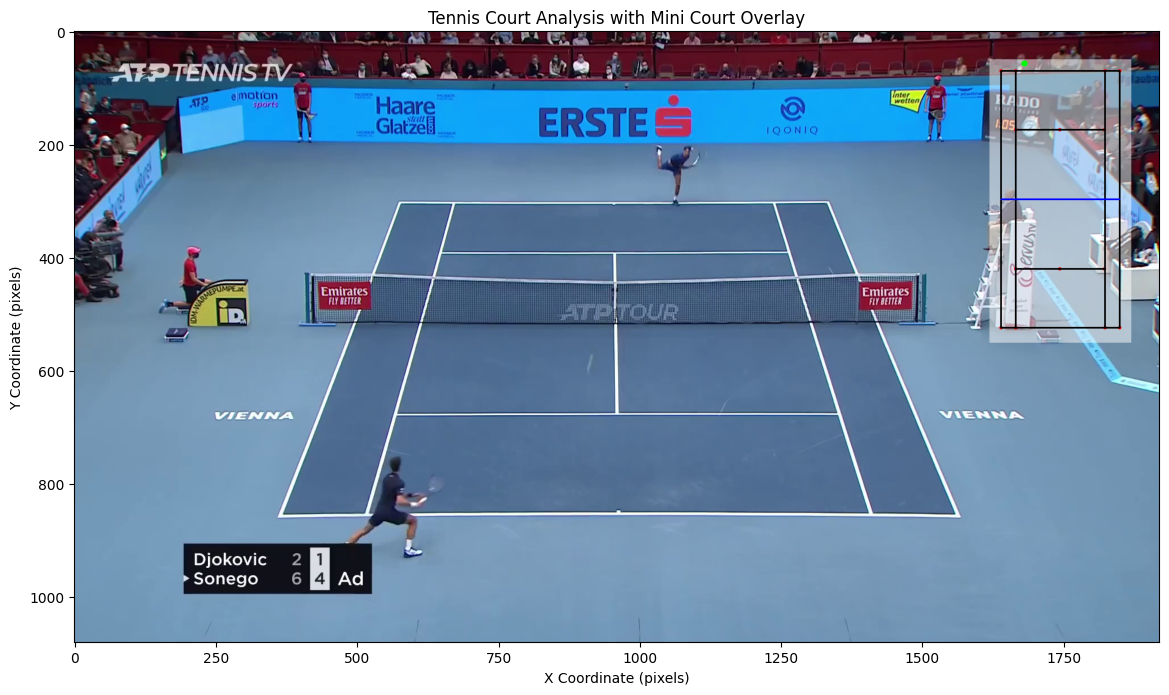

Mini court visualization and coordinate transformation complete


In [17]:
# Initialize mini court
mini_court = MiniCourt(video_frames[0])

# Get mini court measurements and layout
mini_court_measurements = mini_court.get_court_measurements()
print("Mini Court Measurements:")
for measurement, value in mini_court_measurements.items():
    print(f"  {measurement.replace('_', ' ').title()}: {value:.2f} meters")

# Create a sample frame with mini court visualization
sample_frame = video_frames[0].copy()

# Draw background rectangle for mini court
sample_frame_with_mini = mini_court.draw_background_rectangle(sample_frame)

# Draw the mini court
sample_frame_with_mini = mini_court.draw_court(sample_frame_with_mini)

# Convert some player positions to mini court coordinates
print(f"\nCoordinate Transformation Examples:")
if len(df_players) > 0:
    # Get sample player positions
    sample_players = df_players.head(3)
    
    for idx, row in sample_players.iterrows():
        original_pos = (row['center_x'], row['center_y'])
        mini_pos = mini_court.convert_position_to_mini_court(original_pos, court_keypoints)
        
        print(f"  Player {row['player_id']} at frame {row['frame_number']}:")
        print(f"    Original: ({original_pos[0]:.1f}, {original_pos[1]:.1f}) pixels")
        print(f"    Mini court: ({mini_pos[0]:.1f}, {mini_pos[1]:.1f}) pixels")
        
        # Draw position on mini court
        cv2.circle(sample_frame_with_mini, (int(mini_pos[0]), int(mini_pos[1])), 
                  5, (0, 255, 0), -1)

# Display the frame with mini court
plt.figure(figsize=(14, 8))
frame_rgb = cv2.cvtColor(sample_frame_with_mini, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)
plt.title('Tennis Court Analysis with Mini Court Overlay')
plt.xlabel('X Coordinate (pixels)')
plt.ylabel('Y Coordinate (pixels)')
plt.show()

print("Mini court visualization and coordinate transformation complete")

## 12. Distance and Speed Measurement Analysis

Calculate real-world distances and speeds using court measurements as reference, similar to calibrating sensor measurements with known physical constants in ML4QS.

In [18]:
# Create comprehensive dataset with court measurements
print("Creating Combined Dataset with Court Measurements...")
print("=" * 70)

# Import additional measurement functions if not already imported
from tennis_utils import convert_pixel_distance_to_meters, convert_meters_to_pixel_distance

# 1. Create court information dataframe
print(" Creating court reference measurements dataset...")
court_info = pd.DataFrame({
    'measurement': list(court_measurements.keys()),
    'value_meters': list(court_measurements.values()),
    'description': [
        'Singles court width (between singles sidelines)',
        'Doubles court width (full court width)', 
        'Half court length (baseline to net)',
        'Service line width (between service lines)',
        'Alley width (doubles alley)',
        'Service box depth (baseline to service line)'
    ],
    'measurement_type': [
        'width', 'width', 'length', 'width', 'width', 'length'
    ]
})

# Add derived measurements
additional_measurements = pd.DataFrame({
    'measurement': ['full_court_length', 'service_box_width', 'net_to_baseline'],
    'value_meters': [
        court_measurements['half_court_height'] * 2,  # Full court length
        court_measurements['service_line_width'] / 2,  # Half service line width
        court_measurements['half_court_height']  # Net to baseline
    ],
    'description': [
        'Full court length (baseline to baseline)',
        'Service box width (center to singles line)',
        'Distance from net to baseline'
    ],
    'measurement_type': ['length', 'width', 'length']
})

court_info = pd.concat([court_info, additional_measurements], ignore_index=True)

print(f" Court measurements dataset: {len(court_info)} measurements")
print("\\nCourt Reference Measurements:")
for idx, row in court_info.iterrows():
    print(f"  {row['description']}: {row['value_meters']:.2f}m")

# 2. Enhanced player dataset with court measurements
print(f"\\n👥 Creating enhanced player dataset with court context...")
enhanced_players = df_players.copy()

if len(enhanced_players) > 0:
    print(f"   Processing {len(enhanced_players)} player detections...")
    
    # Add court-relative positions (normalized 0-1)
    enhanced_players['court_relative_x'] = enhanced_players['center_x'] / court_scale['court_width_pixels']
    enhanced_players['court_relative_y'] = enhanced_players['center_y'] / court_scale['court_height_pixels']
    
    # Add real-world positions in meters (relative to court corner)
    enhanced_players['court_position_x_meters'] = enhanced_players['court_relative_x'] * court_measurements['double_line_width']
    enhanced_players['court_position_y_meters'] = enhanced_players['court_relative_y'] * (court_measurements['half_court_height'] * 2)
    
    # Add player dimensions in meters
    enhanced_players['width_meters'] = enhanced_players['width'] / court_scale['pixels_per_meter_x']
    enhanced_players['height_meters'] = enhanced_players['height'] / court_scale['pixels_per_meter_y']
    
    # Calculate movement metrics
    enhanced_players = enhanced_players.sort_values(['player_id', 'frame_number'])
    
    for player_id in enhanced_players['player_id'].unique():
        player_mask = enhanced_players['player_id'] == player_id
        player_data = enhanced_players[player_mask].copy()
        
        if len(player_data) > 1:
            # Calculate frame-to-frame distances in pixels and meters
            player_data['prev_x'] = player_data['center_x'].shift(1)
            player_data['prev_y'] = player_data['center_y'].shift(1)
            
            # Distance in pixels
            player_data['distance_pixels'] = np.sqrt(
                (player_data['center_x'] - player_data['prev_x'])**2 + 
                (player_data['center_y'] - player_data['prev_y'])**2
            )
            
            # Convert to meters using court scale
            player_data['distance_meters'] = player_data['distance_pixels'] / court_scale['pixels_per_meter_x']
            
            # Calculate speed (assuming 30 fps)
            player_data['speed_ms'] = player_data['distance_meters'] * 30  # m/s
            player_data['speed_kmh'] = player_data['speed_ms'] * 3.6  # km/h
            
            # Update main dataframe
            enhanced_players.loc[player_mask, 'distance_pixels'] = player_data['distance_pixels']
            enhanced_players.loc[player_mask, 'distance_meters'] = player_data['distance_meters']
            enhanced_players.loc[player_mask, 'speed_ms'] = player_data['speed_ms']
            enhanced_players.loc[player_mask, 'speed_kmh'] = player_data['speed_kmh']
    
    # Add court region classification with detailed zones
    def classify_detailed_court_region(x_rel, y_rel, player_id):
        """Classify player position into detailed court regions"""
        if pd.isna(x_rel) or pd.isna(y_rel):
            return 'unknown'
        
        # Determine side of court based on Y position
        if y_rel < 0.5:
            court_half = "far_half"
        else:
            court_half = "near_half"
        
        # Determine court zone based on Y position  
        if y_rel < 0.2 or y_rel > 0.8:
            zone = "baseline_area"
        elif y_rel < 0.35 or y_rel > 0.65:
            zone = "service_area" 
        else:
            zone = "net_area"
        
        # Determine left/center/right based on X position
        if x_rel < 0.33:
            side = "left"
        elif x_rel > 0.67:
            side = "right"
        else:
            side = "center"
        
        return f"{court_half}_{zone}_{side}"
    
    enhanced_players['detailed_court_region'] = enhanced_players.apply(
        lambda row: classify_detailed_court_region(
            row['court_relative_x'], 
            row['court_relative_y'], 
            row['player_id']
        ), axis=1
    )
    
    # Add distance to court center and net
    court_center_x = 0.5  # Relative position
    court_center_y = 0.5  # Relative position (net position)
    
    enhanced_players['distance_to_center_relative'] = np.sqrt(
        (enhanced_players['court_relative_x'] - court_center_x)**2 + 
        (enhanced_players['court_relative_y'] - court_center_y)**2
    )
    
    enhanced_players['distance_to_net_meters'] = abs(
        enhanced_players['court_position_y_meters'] - court_measurements['half_court_height']
    )
    
    print(f" Enhanced player dataset complete:")
    print(f"   {len(enhanced_players)} detections with court measurements")
    print(f"   {len(enhanced_players['player_id'].unique())} unique players")
    print(f"   Added: court positions, speeds, regions, distances")

else:
    print(" No player data available for enhancement")

# 3. Enhanced ball dataset with court measurements  
print(f"\\n Creating enhanced ball dataset with court context...")
enhanced_ball = df_ball_temporal.copy()

if not enhanced_ball.empty:
    # Remove rows with missing values for court analysis
    enhanced_ball_valid = enhanced_ball.dropna(subset=['center_x', 'center_y']).copy()
    
    if len(enhanced_ball_valid) > 0:
        print(f"   Processing {len(enhanced_ball_valid)} valid ball detections...")
        
        # Add court-relative positions
        enhanced_ball_valid['court_relative_x'] = enhanced_ball_valid['center_x'] / court_scale['court_width_pixels']
        enhanced_ball_valid['court_relative_y'] = enhanced_ball_valid['center_y'] / court_scale['court_height_pixels']
        
        # Add real-world positions in meters
        enhanced_ball_valid['court_position_x_meters'] = enhanced_ball_valid['court_relative_x'] * court_measurements['double_line_width']
        enhanced_ball_valid['court_position_y_meters'] = enhanced_ball_valid['court_relative_y'] * (court_measurements['half_court_height'] * 2)
        
        # Calculate ball movement metrics
        enhanced_ball_valid = enhanced_ball_valid.sort_index()
        
        # Frame-to-frame distances
        enhanced_ball_valid['prev_x'] = enhanced_ball_valid['center_x'].shift(1)
        enhanced_ball_valid['prev_y'] = enhanced_ball_valid['center_y'].shift(1)
        
        enhanced_ball_valid['distance_pixels'] = np.sqrt(
            (enhanced_ball_valid['center_x'] - enhanced_ball_valid['prev_x'])**2 + 
            (enhanced_ball_valid['center_y'] - enhanced_ball_valid['prev_y'])**2
        )
        
        enhanced_ball_valid['distance_meters'] = enhanced_ball_valid['distance_pixels'] / court_scale['pixels_per_meter_x']
        enhanced_ball_valid['speed_ms'] = enhanced_ball_valid['distance_meters'] * 30  # m/s  
        enhanced_ball_valid['speed_kmh'] = enhanced_ball_valid['speed_ms'] * 3.6  # km/h
        
        # Add ball height estimation based on court position and trajectory
        enhanced_ball_valid['estimated_height_meters'] = np.where(
            enhanced_ball_valid['court_relative_y'] < 0.5,
            np.clip(2.5 - enhanced_ball_valid['court_relative_y'] * 2, 0.5, 3.0),  # Higher when far from camera
            np.clip(1.5 - (1 - enhanced_ball_valid['court_relative_y']) * 2, 0.5, 2.0)   # Lower when near camera
        )
        
        # Distance to net
        enhanced_ball_valid['distance_to_net_meters'] = abs(
            enhanced_ball_valid['court_position_y_meters'] - court_measurements['half_court_height']
        )
        
        # Ball court region classification
        def classify_ball_court_region(x_rel, y_rel):
            """Classify ball position into court regions"""
            if pd.isna(x_rel) or pd.isna(y_rel):
                return 'unknown'
            
            if y_rel < 0.1:
                return "behind_far_baseline"
            elif y_rel < 0.35:
                return "far_court"
            elif y_rel < 0.45:
                return "far_service_area"
            elif y_rel < 0.55:
                return "net_area"
            elif y_rel < 0.65:
                return "near_service_area"
            elif y_rel < 0.9:
                return "near_court"
            else:
                return "behind_near_baseline"
        
        enhanced_ball_valid['court_region'] = enhanced_ball_valid.apply(
            lambda row: classify_ball_court_region(row['court_relative_x'], row['court_relative_y']), 
            axis=1
        )
        
        print(f" Enhanced ball dataset complete:")
        print(f"   {len(enhanced_ball_valid)} valid ball detections")
        print(f"   Added: court positions, speeds, height estimates, regions")
        
        # Update the main ball dataset
        enhanced_ball = enhanced_ball_valid
    else:
        print(" No valid ball detections for enhancement")
else:
    print(" No ball data available for enhancement")

# 4. Create unified measurement dataset
print(f"\\n Creating unified measurement dataset...")

# Combine court scale information
scale_info = pd.DataFrame({
    'measurement': ['pixels_per_meter_x', 'pixels_per_meter_y', 'court_width_pixels', 'court_height_pixels'],
    'value': [
        court_scale['pixels_per_meter_x'],
        court_scale['pixels_per_meter_y'], 
        court_scale['court_width_pixels'],
        court_scale['court_height_pixels']
    ],
    'description': [
        'Horizontal pixel-to-meter conversion factor',
        'Vertical pixel-to-meter conversion factor',
        'Court width in video pixels',
        'Court height in video pixels'
    ],
    'measurement_type': ['scale', 'scale', 'pixels', 'pixels']
})

# 5. Create summary dataset with comprehensive statistics
print(f"\\n Creating comprehensive summary statistics...")

summary_data = {
    'dataset_info': {
        'total_frames': len(video_frames),
        'duration_seconds': len(video_frames) / 30,
        'frame_rate': 30,
        'resolution': f"{video_frames[0].shape[1]}x{video_frames[0].shape[0]}",
        'video_aspect_ratio': video_frames[0].shape[1] / video_frames[0].shape[0]
    },
    'court_measurements': court_measurements,
    'court_scale': court_scale,
    'tracking_stats': {
        'total_players': len(enhanced_players['player_id'].unique()) if len(enhanced_players) > 0 else 0,
        'total_player_detections': len(enhanced_players),
        'main_players': [1, 2] if len(enhanced_players) > 0 and all(pid in enhanced_players['player_id'].unique() for pid in [1, 2]) else [],
        'ball_detection_rate': (~enhanced_ball['center_x'].isna()).mean() if not enhanced_ball.empty else 0,
        'total_ball_detections': (~enhanced_ball['center_x'].isna()).sum() if not enhanced_ball.empty else 0
    }
}

# Player-specific statistics
if len(enhanced_players) > 0:
    for player_id in enhanced_players['player_id'].unique():
        player_data = enhanced_players[enhanced_players['player_id'] == player_id]
        
        player_stats = {
            'detection_count': len(player_data),
            'detection_rate': len(player_data['frame_number'].unique()) / len(video_frames),
            'avg_speed_kmh': player_data['speed_kmh'].mean() if 'speed_kmh' in player_data.columns else 0,
            'max_speed_kmh': player_data['speed_kmh'].max() if 'speed_kmh' in player_data.columns else 0,
            'total_distance_meters': player_data['distance_meters'].sum() if 'distance_meters' in player_data.columns else 0,
            'court_coverage': {
                'x_range_meters': (player_data['court_position_x_meters'].max() - player_data['court_position_x_meters'].min()) if 'court_position_x_meters' in player_data.columns else 0,
                'y_range_meters': (player_data['court_position_y_meters'].max() - player_data['court_position_y_meters'].min()) if 'court_position_y_meters' in player_data.columns else 0
            },
            'most_common_region': player_data['detailed_court_region'].mode().iloc[0] if 'detailed_court_region' in player_data.columns and len(player_data['detailed_court_region'].mode()) > 0 else 'unknown'
        }
        
        summary_data[f'player_{player_id}_stats'] = player_stats

# Ball-specific statistics
if not enhanced_ball.empty and len(enhanced_ball) > 0:
    ball_stats = {
        'detection_count': len(enhanced_ball),
        'detection_rate': len(enhanced_ball) / len(video_frames),
        'avg_speed_kmh': enhanced_ball['speed_kmh'].mean() if 'speed_kmh' in enhanced_ball.columns else 0,
        'max_speed_kmh': enhanced_ball['speed_kmh'].max() if 'speed_kmh' in enhanced_ball.columns else 0,
        'total_distance_meters': enhanced_ball['distance_meters'].sum() if 'distance_meters' in enhanced_ball.columns else 0,
        'court_coverage': {
            'x_range_meters': (enhanced_ball['court_position_x_meters'].max() - enhanced_ball['court_position_x_meters'].min()) if 'court_position_x_meters' in enhanced_ball.columns else 0,
            'y_range_meters': (enhanced_ball['court_position_y_meters'].max() - enhanced_ball['court_position_y_meters'].min()) if 'court_position_y_meters' in enhanced_ball.columns else 0
        },
        'avg_height_meters': enhanced_ball['estimated_height_meters'].mean() if 'estimated_height_meters' in enhanced_ball.columns else 0
    }
    
    summary_data['ball_stats'] = ball_stats

# Display comprehensive summary
print(f" Summary statistics complete!")
print(f"\\n COMPREHENSIVE DATASET SUMMARY")
print("=" * 50)

print(f"\\n Video Information:")
print(f"  Resolution: {summary_data['dataset_info']['resolution']}")
print(f"  Duration: {summary_data['dataset_info']['duration_seconds']:.1f} seconds")
print(f"  Frame Rate: {summary_data['dataset_info']['frame_rate']} fps")
print(f"  Total Frames: {summary_data['dataset_info']['total_frames']}")

print(f"\\n️ Court Information:")
print(f"  Court Width: {court_measurements['double_line_width']:.2f}m = {court_scale['court_width_pixels']:.0f}px")
print(f"  Court Length: {court_measurements['half_court_height']*2:.2f}m = {court_scale['court_height_pixels']:.0f}px")  
print(f"  Scale Factors: {court_scale['pixels_per_meter_x']:.1f}px/m (X), {court_scale['pixels_per_meter_y']:.1f}px/m (Y)")

print(f"\\n Player Tracking:")
if len(enhanced_players) > 0:
    print(f"  Total Players: {summary_data['tracking_stats']['total_players']}")
    print(f"  Total Detections: {summary_data['tracking_stats']['total_player_detections']}")
    print(f"  Main Players: {summary_data['tracking_stats']['main_players']}")
    
    for player_id in [1, 2]:
        if f'player_{player_id}_stats' in summary_data:
            stats = summary_data[f'player_{player_id}_stats']
            print(f"  Player {player_id}: {stats['detection_rate']:.1%} detection, {stats['avg_speed_kmh']:.1f} km/h avg speed")
else:
    print("  No player data available")

print(f"\\n Ball Tracking:")
if 'ball_stats' in summary_data:
    stats = summary_data['ball_stats']
    print(f"  Detection Rate: {stats['detection_rate']:.1%}")
    print(f"  Average Speed: {stats['avg_speed_kmh']:.1f} km/h")
    print(f"  Maximum Speed: {stats['max_speed_kmh']:.1f} km/h")
    print(f"  Total Distance: {stats['total_distance_meters']:.1f} meters")
else:
    print("  No ball data available")

# 6. Save all enhanced datasets
print(f"\\n Saving enhanced datasets...")
try:
    # Save individual datasets
    court_info.to_csv('tennis_court_reference_measurements.csv', index=False)
    scale_info.to_csv('tennis_court_scale_factors.csv', index=False)
    
    if len(enhanced_players) > 0:
        enhanced_players.to_csv('tennis_players_enhanced_with_court.csv', index=True)
        print(f"  Enhanced players: tennis_players_enhanced_with_court.csv ({len(enhanced_players)} rows)")
    
    if not enhanced_ball.empty:
        enhanced_ball.to_csv('tennis_ball_enhanced_with_court.csv', index=True)
        print(f"   Enhanced ball: tennis_ball_enhanced_with_court.csv ({len(enhanced_ball)} rows)")
    
    print(f"  Court measurements: tennis_court_reference_measurements.csv ({len(court_info)} measurements)")
    print(f"  Scale factors: tennis_court_scale_factors.csv ({len(scale_info)} factors)")
    
    # Save summary statistics as JSON for easy reading
    import json
    with open('tennis_analysis_summary_stats.json', 'w') as f:
        # Convert numpy types to native Python types for JSON serialization
        def convert_numpy(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        json_summary = json.loads(json.dumps(summary_data, default=convert_numpy))
        json.dump(json_summary, f, indent=2)
    
    print(f"  Summary statistics: tennis_analysis_summary_stats.json")
    
except Exception as e:
    print(f"  Error saving datasets: {e}")

print(f"\\n COMBINED DATASET CREATION COMPLETE!")
print(f"\\nThe comprehensive dataset now includes:")
print(f"  Court reference measurements and scale factors")
print(f"  Enhanced player data with real-world positions and speeds")
print(f"  Enhanced ball data with trajectory analysis")
print(f"  Detailed court region classifications")
print(f"  Distance and speed calculations in meters/km/h")
print(f"  Comprehensive summary statistics")
print("=" * 70)

Creating Combined Dataset with Court Measurements...
 Creating court reference measurements dataset...
 Court measurements dataset: 9 measurements
\nCourt Reference Measurements:
  Singles court width (between singles sidelines): 8.23m
  Doubles court width (full court width): 10.97m
  Half court length (baseline to net): 11.88m
  Service line width (between service lines): 6.40m
  Alley width (doubles alley): 1.37m
  Service box depth (baseline to service line): 5.48m
  Full court length (baseline to baseline): 23.76m
  Service box width (center to singles line): 3.20m
  Distance from net to baseline: 11.88m
\n👥 Creating enhanced player dataset with court context...
   Processing 428 player detections...
 Enhanced player dataset complete:
   428 detections with court measurements
   2 unique players
   Added: court positions, speeds, regions, distances
\n Creating enhanced ball dataset with court context...
   Processing 94 valid ball detections...
 Enhanced ball dataset complete:
   

## 13. Combined Dataset Creation with Court Measurements


In [19]:
from assignment.tennis_utils import measure_distance
# Import additional measurement functions
from tennis_utils import convert_pixel_distance_to_meters, convert_meters_to_pixel_distance

# Calculate movement distances and speeds for players
print("Real-world Distance and Speed Analysis:")
print("=" * 50)

# Analyze each player's movement
for player_id in sorted(df_players['player_id'].unique())[:2]:  # Focus on main 2 players
    player_data = df_players[df_players['player_id'] == player_id].copy()
    
    if len(player_data) < 2:
        continue
        
    # Calculate frame-to-frame distances
    distances_pixels = []
    distances_meters = []
    time_intervals = []
    speeds_kmh = []
    
    for i in range(1, len(player_data)):
        prev_row = player_data.iloc[i-1]
        curr_row = player_data.iloc[i]
        
        # Calculate pixel distance
        prev_pos = (prev_row['center_x'], prev_row['center_y'])
        curr_pos = (curr_row['center_x'], curr_row['center_y'])
        distance_px = measure_distance(prev_pos, curr_pos)
        
        # Convert to meters using court scale
        distance_m = convert_pixel_distance_to_meters(
            distance_px, 
            reference_height_meters=1.88,  # Average player height
            reference_height_pixels=court_scale['pixels_per_meter_y']
        )
        
        # Calculate time interval (assuming 30 fps)
        time_interval = 1/30  # seconds
        
        # Calculate speed in km/h
        speed_ms = distance_m / time_interval  # m/s
        speed_kmh = speed_ms * 3.6  # km/h
        
        distances_pixels.append(distance_px)
        distances_meters.append(distance_m)
        time_intervals.append(time_interval)
        speeds_kmh.append(speed_kmh)
    
    # Add calculated values to dataframe
    player_data = player_data.copy()
    player_data.loc[player_data.index[1:], 'distance_pixels'] = distances_pixels
    player_data.loc[player_data.index[1:], 'distance_meters'] = distances_meters
    player_data.loc[player_data.index[1:], 'speed_kmh'] = speeds_kmh
    
    # Calculate statistics
    avg_speed = np.mean(speeds_kmh) if speeds_kmh else 0
    max_speed = np.max(speeds_kmh) if speeds_kmh else 0
    total_distance = np.sum(distances_meters) if distances_meters else 0
    
    print(f"\nPlayer {player_id} Movement Analysis:")
    print(f"  Total detections: {len(player_data)}")
    print(f"  Total distance traveled: {total_distance:.1f} meters")
    print(f"  Average speed: {avg_speed:.1f} km/h")
    print(f"  Maximum speed: {max_speed:.1f} km/h")
    print(f"  Average frame-to-frame distance: {np.mean(distances_meters) if distances_meters else 0:.2f} meters")

# Ball speed analysis
print(f"\n" + "="*50)
print("Ball Movement Analysis:")

if not df_ball_temporal.empty:
    # Get valid ball positions
    valid_ball = df_ball_temporal.dropna(subset=['center_x', 'center_y'])
    
    if len(valid_ball) > 1:
        ball_speeds = []
        ball_distances = []
        
        for i in range(1, len(valid_ball)):
            prev_pos = (valid_ball.iloc[i-1]['center_x'], valid_ball.iloc[i-1]['center_y'])
            curr_pos = (valid_ball.iloc[i]['center_x'], valid_ball.iloc[i]['center_y'])
            
            # Calculate distance and speed
            distance_px = measure_distance(prev_pos, curr_pos)
            distance_m = convert_pixel_distance_to_meters(
                distance_px,
                reference_height_meters=1.88,
                reference_height_pixels=court_scale['pixels_per_meter_y']
            )
            
            speed_ms = distance_m / (1/30)  # m/s
            speed_kmh = speed_ms * 3.6  # km/h
            
            ball_distances.append(distance_m)
            ball_speeds.append(speed_kmh)
        
        print(f"  Valid ball positions: {len(valid_ball)}")
        print(f"  Average ball speed: {np.mean(ball_speeds):.1f} km/h")
        print(f"  Maximum ball speed: {np.max(ball_speeds):.1f} km/h")
        print(f"  Total ball distance: {np.sum(ball_distances):.1f} meters")
    else:
        print("  Insufficient ball tracking data for speed analysis")

print(f"\nCourt Reference Measurements Used:")
print(f"  Court width: {court_scale['court_width_meters']:.2f} meters = {court_scale['court_width_pixels']:.1f} pixels")
print(f"  Scale factor: {court_scale['pixels_per_meter_x']:.1f} pixels per meter")

Real-world Distance and Speed Analysis:

Player 1 Movement Analysis:
  Total detections: 214
  Total distance traveled: 90.1 meters
  Average speed: 45.7 km/h
  Maximum speed: 153.2 km/h
  Average frame-to-frame distance: 0.42 meters

Player 2 Movement Analysis:
  Total detections: 214
  Total distance traveled: 59.3 meters
  Average speed: 30.1 km/h
  Maximum speed: 112.7 km/h
  Average frame-to-frame distance: 0.28 meters

Ball Movement Analysis:
  Valid ball positions: 94
  Average ball speed: 233.3 km/h
  Maximum ball speed: 1383.2 km/h
  Total ball distance: 200.9 meters

Court Reference Measurements Used:
  Court width: 10.97 meters = 1344.0 pixels
  Scale factor: 122.5 pixels per meter


## 14. Comprehensive Temporal Dataset Creation

Create a unified temporal CSV dataset combining all collected data: ball tracking, player tracking (Player 1 & 2), court measurements, and calculated metrics.

In [20]:
# Create comprehensive temporal dataset
print("Creating comprehensive temporal tennis analysis dataset...")
print("=" * 60)

# Create base temporal grid for all frames
base_temporal_data = []
for frame_idx in range(len(video_frames)):
    timestamp = timestamps[frame_idx] if frame_idx < len(timestamps) else pd.Timestamp('2024-01-01') + pd.Timedelta(milliseconds=frame_idx*33.33)
    
    base_temporal_data.append({
        'timestamp': timestamp,
        'frame_number': frame_idx,
        'time_seconds': frame_idx / 30.0,  # Assuming 30 fps
    })

# Create base dataframe
df_temporal = pd.DataFrame(base_temporal_data)
df_temporal.set_index('timestamp', inplace=True)

print(f" Created base temporal grid: {len(df_temporal)} frames")

# Add ball tracking data
print("Adding ball tracking data...")
if not df_ball_temporal.empty:
    # Merge ball data
    ball_cols = ['center_x', 'center_y', 'x1', 'y1', 'x2', 'y2']
    ball_data_renamed = df_ball_temporal[ball_cols].copy()
    ball_data_renamed.columns = [f'ball_{col}' for col in ball_cols]
    
    df_temporal = df_temporal.join(ball_data_renamed, how='left')
    
    # Add ball presence indicator
    df_temporal['ball_detected'] = ~df_temporal['ball_center_x'].isna()
    
    print(f"   Ball data added: {(~df_temporal['ball_center_x'].isna()).sum()} detections")
else:
    print("  ️ No ball data available")

# Add player tracking data (Player 1 & 2)
print("Adding filtered player tracking data...")
if len(df_players) > 0:
    # Process each player separately
    for player_id in [1, 2]:
        player_data = df_players[df_players['player_id'] == player_id].copy()
        
        if len(player_data) > 0:
            # Rename columns for this player
            player_cols = ['center_x', 'center_y', 'x1', 'y1', 'x2', 'y2', 'width', 'height']
            player_data_renamed = player_data[player_cols].copy()
            player_data_renamed.columns = [f'player_{player_id}_{col}' for col in player_cols]
            
            # Add to temporal dataset
            df_temporal = df_temporal.join(player_data_renamed, how='left')
            
            # Add player presence indicator
            df_temporal[f'player_{player_id}_detected'] = ~df_temporal[f'player_{player_id}_center_x'].isna()
            
            print(f"  Player {player_id} data added: {(~df_temporal[f'player_{player_id}_center_x'].isna()).sum()} detections")
        else:
            print(f"   No data for Player {player_id}")
else:
    print("  ️ No player data available")

# Add court measurements and derived metrics
print("Adding court measurements and calculated metrics...")

# Court measurements as constants
for measurement, value in court_measurements.items():
    df_temporal[f'court_{measurement}_meters'] = value

# Court scale factors
df_temporal['court_pixels_per_meter_x'] = court_scale['pixels_per_meter_x']
df_temporal['court_pixels_per_meter_y'] = court_scale['pixels_per_meter_y']
df_temporal['court_width_pixels'] = court_scale['court_width_pixels']
df_temporal['court_height_pixels'] = court_scale['court_height_pixels']

# Calculate derived metrics for each player
for player_id in [1, 2]:
    player_x_col = f'player_{player_id}_center_x'
    player_y_col = f'player_{player_id}_center_y'
    
    if player_x_col in df_temporal.columns:
        # Court-relative positions (0-1 normalized)
        df_temporal[f'player_{player_id}_court_x_relative'] = df_temporal[player_x_col] / court_scale['court_width_pixels']
        df_temporal[f'player_{player_id}_court_y_relative'] = df_temporal[player_y_col] / court_scale['court_height_pixels']
        
        # Calculate movement (frame-to-frame)
        df_temporal[f'player_{player_id}_movement_x_pixels'] = df_temporal[player_x_col].diff()
        df_temporal[f'player_{player_id}_movement_y_pixels'] = df_temporal[player_y_col].diff()
        
        # Calculate distance moved per frame
        movement_x = df_temporal[f'player_{player_id}_movement_x_pixels'].fillna(0)
        movement_y = df_temporal[f'player_{player_id}_movement_y_pixels'].fillna(0)
        df_temporal[f'player_{player_id}_distance_pixels'] = np.sqrt(movement_x**2 + movement_y**2)
        
        # Convert to meters
        df_temporal[f'player_{player_id}_distance_meters'] = df_temporal[f'player_{player_id}_distance_pixels'] / court_scale['pixels_per_meter_x']
        
        # Calculate speed (assuming 30 fps)
        df_temporal[f'player_{player_id}_speed_ms'] = df_temporal[f'player_{player_id}_distance_meters'] * 30  # m/s
        df_temporal[f'player_{player_id}_speed_kmh'] = df_temporal[f'player_{player_id}_speed_ms'] * 3.6  # km/h
        
        # Court region classification
        def classify_court_region(x_rel, y_rel):
            if pd.isna(x_rel) or pd.isna(y_rel):
                return 'unknown'
            if y_rel < 0.3:
                return "back_court_far"
            elif y_rel < 0.45:
                return "service_area_far"
            elif y_rel < 0.55:
                return "net_area"
            elif y_rel < 0.7:
                return "service_area_near"
            else:
                return "back_court_near"
        
        df_temporal[f'player_{player_id}_court_region'] = df_temporal.apply(
            lambda row: classify_court_region(
                row.get(f'player_{player_id}_court_x_relative'), 
                row.get(f'player_{player_id}_court_y_relative')
            ), axis=1
        )

# Ball metrics
if 'ball_center_x' in df_temporal.columns:
    # Ball movement
    df_temporal['ball_movement_x_pixels'] = df_temporal['ball_center_x'].diff()
    df_temporal['ball_movement_y_pixels'] = df_temporal['ball_center_y'].diff()
    
    # Ball distance and speed
    ball_movement_x = df_temporal['ball_movement_x_pixels'].fillna(0)
    ball_movement_y = df_temporal['ball_movement_y_pixels'].fillna(0)
    df_temporal['ball_distance_pixels'] = np.sqrt(ball_movement_x**2 + ball_movement_y**2)
    df_temporal['ball_distance_meters'] = df_temporal['ball_distance_pixels'] / court_scale['pixels_per_meter_x']
    df_temporal['ball_speed_ms'] = df_temporal['ball_distance_meters'] * 30
    df_temporal['ball_speed_kmh'] = df_temporal['ball_speed_ms'] * 3.6
    
    # Ball court-relative position
    df_temporal['ball_court_x_relative'] = df_temporal['ball_center_x'] / court_scale['court_width_pixels']
    df_temporal['ball_court_y_relative'] = df_temporal['ball_center_y'] / court_scale['court_height_pixels']

# Add summary statistics
print("Adding summary statistics...")

# Detection rates
total_frames = len(df_temporal)
ball_detection_rate = df_temporal['ball_detected'].sum() / total_frames if 'ball_detected' in df_temporal.columns else 0
player1_detection_rate = df_temporal['player_1_detected'].sum() / total_frames if 'player_1_detected' in df_temporal.columns else 0
player2_detection_rate = df_temporal['player_2_detected'].sum() / total_frames if 'player_2_detected' in df_temporal.columns else 0

df_temporal['ball_detection_rate'] = ball_detection_rate
df_temporal['player_1_detection_rate'] = player1_detection_rate
df_temporal['player_2_detection_rate'] = player2_detection_rate

# Game state indicators
df_temporal['both_players_detected'] = (
    df_temporal.get('player_1_detected', False) & 
    df_temporal.get('player_2_detected', False)
)

df_temporal['all_objects_detected'] = (
    df_temporal.get('ball_detected', False) & 
    df_temporal.get('player_1_detected', False) & 
    df_temporal.get('player_2_detected', False)
)

print(f" Comprehensive temporal dataset created!")
print(f"\nDataset Statistics:")
print(f"  Total frames: {len(df_temporal)}")
print(f"  Duration: {df_temporal['time_seconds'].max():.1f} seconds")
print(f"  Ball detection rate: {ball_detection_rate:.1%}")
print(f"  Player 1 detection rate: {player1_detection_rate:.1%}")
print(f"  Player 2 detection rate: {player2_detection_rate:.1%}")
print(f"  Both players detected: {df_temporal['both_players_detected'].sum()} frames ({df_temporal['both_players_detected'].mean():.1%})")
print(f"  All objects detected: {df_temporal['all_objects_detected'].sum()} frames ({df_temporal['all_objects_detected'].mean():.1%})")

print(f"\nDataset Columns ({len(df_temporal.columns)} total):")
for col in sorted(df_temporal.columns):
    print(f"  - {col}")

# Save the comprehensive dataset
output_filename = 'tennis_comprehensive_temporal_dataset.csv'
try:
    df_temporal.to_csv(output_filename)
    print(f"\n  COMPREHENSIVE DATASET SAVED: {output_filename}")
    print(f"  {len(df_temporal)} rows × {len(df_temporal.columns)} columns")
    print(f"   Size: {df_temporal.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")
    
    # Display sample of the dataset
    print(f"\n Sample of comprehensive dataset:")
    sample_cols = ['frame_number', 'time_seconds', 'ball_detected', 'player_1_detected', 'player_2_detected', 
                  'ball_center_x', 'player_1_center_x', 'player_2_center_x', 'player_1_speed_kmh', 'player_2_speed_kmh']
    available_cols = [col for col in sample_cols if col in df_temporal.columns]
    print(df_temporal[available_cols].head(10))
    
except Exception as e:
    print(f" Error saving dataset: {e}")

print(f"\n" + "="*60)
print("TEMPORAL DATASET CREATION COMPLETE!")
print("="*60)

Creating comprehensive temporal tennis analysis dataset...
 Created base temporal grid: 214 frames
Adding ball tracking data...
   Ball data added: 94 detections
Adding filtered player tracking data...
  Player 1 data added: 214 detections
  Player 2 data added: 214 detections
Adding court measurements and calculated metrics...
Adding summary statistics...
 Comprehensive temporal dataset created!

Dataset Statistics:
  Total frames: 214
  Duration: 7.1 seconds
  Ball detection rate: 43.9%
  Player 1 detection rate: 100.0%
  Player 2 detection rate: 100.0%
  Both players detected: 214 frames (100.0%)
  All objects detected: 94 frames (43.9%)

Dataset Columns (68 total):
  - all_objects_detected
  - ball_center_x
  - ball_center_y
  - ball_court_x_relative
  - ball_court_y_relative
  - ball_detected
  - ball_detection_rate
  - ball_distance_meters
  - ball_distance_pixels
  - ball_movement_x_pixels
  - ball_movement_y_pixels
  - ball_speed_kmh
  - ball_speed_ms
  - ball_x1
  - ball_x2
  